In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np 
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

# Preprocessing
- Resolve the image paths
- Extract the labels from the path
- Move the data to a `pandas` `dataframe` for convenience
- Generate batches of tensor image data with real-time data augmentation using `ImageDataGenerator`.

## Data Retrieval

In [3]:
dataset_path = Path("/kaggle/input")
images = list(dataset_path.glob(r'**/*.png'))
labels = list(map(lambda x: x.parents[0].stem, images))

In [4]:
# getting the dataset in a Dataframe for convenience

images = pd.Series(images, name="Images").astype(str)
labels = pd.Series(labels, name="Labels").astype(str)

data = pd.concat([images, labels], axis = 1)
data = data.sample(frac = 1, random_state = 42).reset_index(drop = True)
data.head()

,Images,Labels
0,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Small-flowered Cranesbill
1,/kaggle/input/v2-plant-seedlings-dataset/Commo...,Common Chickweed
2,/kaggle/input/v2-plant-seedlings-dataset/Loose...,Loose Silky-bent
3,/kaggle/input/v2-plant-seedlings-dataset/Black...,Black-grass
4,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Sugar beet


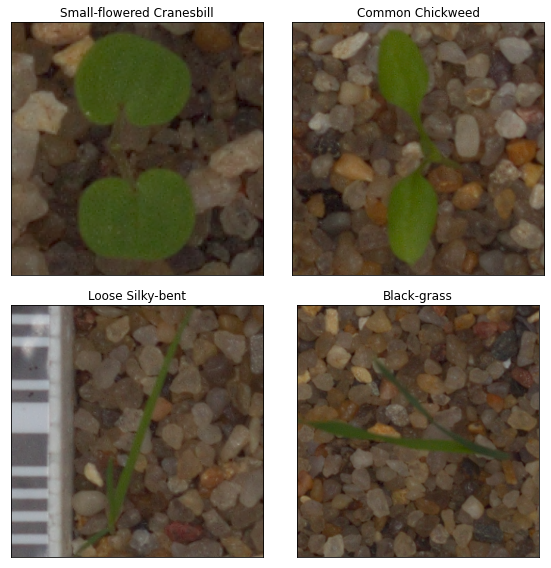

In [5]:
# small sample of the data
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(imageio.imread(data.Images[i]))
  ax.set_title(data.Labels[i])
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()

## Data Augmentations

> For EfficientNet-B0 the input image size used is (224, 224, 3)

- Horizontal Flipping
- Shearing
- Scaling
- Translation
- Rotation
- Brightness Shift

In [6]:
# Using a tensorflow ImageDataGenerator for generating the training data
# This will handle the io along with any augmentations to be done to the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet

train_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input,
    validation_split = 0.1
)

test_generator_eff_net = ImageDataGenerator(
    preprocessing_function = efficientnet.preprocess_input
)

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    data, 
    train_size=0.9, 
    shuffle=True, 
    random_state=42,
    stratify=data[["Labels"]]
)

train = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    fill_mode="nearest"
)

validation = train_generator_eff_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5,1.5],
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test = test_generator_eff_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

Found 8973 validated image filenames belonging to 12 classes.
Found 997 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


# Building the Model

## [EffcientNet](https://arxiv.org/abs/1905.11946)

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients. For example, if we want to use `2^N` times more computational resources, then we can simply increase the network depth by `α^N`, width by `β^N`, and image size by `γ^N`, where  are constant coefficients determined by a small grid search on the original small model. EfficientNet uses a compound coefficient  to uniformly scales network width, depth, and resolution in a principled way.

The base EfficientNet-B0 network is based on the inverted bottleneck residual blocks of MobileNetV2, in addition to squeeze-and-excitation blocks.

In [8]:
basemodel = efficientnet.EfficientNetB0(
                                          include_top=False,
                                          weights='imagenet',
                                          input_shape=(224,224,3), 
                                          pooling='avg',
                                        )
# basemodel.summary()
basemodel.trainable = False

16719872/16705208 [==============================] - 2s 0us/step


In [9]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(256, activation='relu')(basemodel.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(12, activation='softmax')(x)

efficientnet = Model(inputs=basemodel.inputs, outputs=outputs)

In [10]:
efficientnet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [11]:
CHECKPOINTS = Path("./checkpoints")
CHECKPOINTS.mkdir(exist_ok=True)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# training
results = efficientnet.fit(
    train,
    validation_data = validation,
    batch_size = 32,
    epochs = 40,
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(patience=2),
        ModelCheckpoint(
        str(CHECKPOINTS),
        monitor="val_loss",
        save_best_only=True)
    ]
)

Epoch 1/40
281/281 [==============================] - 149s 489ms/step - loss: 0.9830 - categorical_accuracy: 0.6586 - val_loss: 0.4022 - val_categorical_accuracy: 0.8626


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
281/281 [==============================] - 101s 358ms/step - loss: 0.4550 - categorical_accuracy: 0.8401 - val_loss: 0.2688 - val_categorical_accuracy: 0.9067


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/40
281/281 [==============================] - 98s 348ms/step - loss: 0.3495 - categorical_accuracy: 0.8765 - val_loss: 0.2241 - val_categorical_accuracy: 0.9258


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/40
281/281 [==============================] - 97s 346ms/step - loss: 0.3038 - categorical_accuracy: 0.8938 - val_loss: 0.1914 - val_categorical_accuracy: 0.9318


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/40
281/281 [==============================] - 99s 352ms/step - loss: 0.2575 - categorical_accuracy: 0.9120 - val_loss: 0.1536 - val_categorical_accuracy: 0.9468


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/40
281/281 [==============================] - 98s 349ms/step - loss: 0.2170 - categorical_accuracy: 0.9273 - val_loss: 0.1773 - val_categorical_accuracy: 0.9378
Epoch 7/40
281/281 [==============================] - 98s 350ms/step - loss: 0.2011 - categorical_accuracy: 0.9315 - val_loss: 0.1468 - val_categorical_accuracy: 0.9478


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/40
281/281 [==============================] - 99s 351ms/step - loss: 0.1808 - categorical_accuracy: 0.9383 - val_loss: 0.1280 - val_categorical_accuracy: 0.9458


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/40
281/281 [==============================] - 98s 347ms/step - loss: 0.1614 - categorical_accuracy: 0.9439 - val_loss: 0.1745 - val_categorical_accuracy: 0.9408
Epoch 10/40
281/281 [==============================] - 98s 350ms/step - loss: 0.1636 - categorical_accuracy: 0.9415 - val_loss: 0.1143 - val_categorical_accuracy: 0.9549


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/40
281/281 [==============================] - 98s 348ms/step - loss: 0.1481 - categorical_accuracy: 0.9513 - val_loss: 0.1233 - val_categorical_accuracy: 0.9609
Epoch 12/40
281/281 [==============================] - 98s 349ms/step - loss: 0.1388 - categorical_accuracy: 0.9529 - val_loss: 0.1469 - val_categorical_accuracy: 0.9509
Epoch 13/40
281/281 [==============================] - 98s 348ms/step - loss: 0.0934 - categorical_accuracy: 0.9700 - val_loss: 0.0693 - val_categorical_accuracy: 0.9789


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/40
281/281 [==============================] - 101s 361ms/step - loss: 0.0751 - categorical_accuracy: 0.9756 - val_loss: 0.0703 - val_categorical_accuracy: 0.9779
Epoch 15/40
281/281 [==============================] - 98s 349ms/step - loss: 0.0718 - categorical_accuracy: 0.9767 - val_loss: 0.0697 - val_categorical_accuracy: 0.9799
Epoch 16/40
281/281 [==============================] - 99s 353ms/step - loss: 0.0719 - categorical_accuracy: 0.9762 - val_loss: 0.0669 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/40
281/281 [==============================] - 98s 348ms/step - loss: 0.0644 - categorical_accuracy: 0.9798 - val_loss: 0.0662 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/40
281/281 [==============================] - 99s 351ms/step - loss: 0.0682 - categorical_accuracy: 0.9784 - val_loss: 0.0656 - val_categorical_accuracy: 0.9799


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/40
281/281 [==============================] - 100s 354ms/step - loss: 0.0688 - categorical_accuracy: 0.9802 - val_loss: 0.0649 - val_categorical_accuracy: 0.9799


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/40
281/281 [==============================] - 98s 348ms/step - loss: 0.0691 - categorical_accuracy: 0.9784 - val_loss: 0.0640 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/40
281/281 [==============================] - 98s 347ms/step - loss: 0.0627 - categorical_accuracy: 0.9804 - val_loss: 0.0651 - val_categorical_accuracy: 0.9799
Epoch 22/40
281/281 [==============================] - 98s 349ms/step - loss: 0.0657 - categorical_accuracy: 0.9796 - val_loss: 0.0638 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/40
281/281 [==============================] - 99s 352ms/step - loss: 0.0592 - categorical_accuracy: 0.9815 - val_loss: 0.0631 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/40
281/281 [==============================] - 97s 347ms/step - loss: 0.0611 - categorical_accuracy: 0.9832 - val_loss: 0.0640 - val_categorical_accuracy: 0.9799
Epoch 25/40
281/281 [==============================] - 97s 345ms/step - loss: 0.0674 - categorical_accuracy: 0.9794 - val_loss: 0.0631 - val_categorical_accuracy: 0.9809
Epoch 26/40
281/281 [==============================] - 98s 348ms/step - loss: 0.0639 - categorical_accuracy: 0.9792 - val_loss: 0.0629 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/40
281/281 [==============================] - 98s 349ms/step - loss: 0.0608 - categorical_accuracy: 0.9803 - val_loss: 0.0628 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/40
281/281 [==============================] - 101s 359ms/step - loss: 0.0628 - categorical_accuracy: 0.9794 - val_loss: 0.0627 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/40
281/281 [==============================] - 98s 349ms/step - loss: 0.0647 - categorical_accuracy: 0.9794 - val_loss: 0.0626 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/40
281/281 [==============================] - 98s 347ms/step - loss: 0.0612 - categorical_accuracy: 0.9816 - val_loss: 0.0624 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/40
281/281 [==============================] - 99s 352ms/step - loss: 0.0623 - categorical_accuracy: 0.9804 - val_loss: 0.0623 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/40
281/281 [==============================] - 98s 349ms/step - loss: 0.0618 - categorical_accuracy: 0.9796 - val_loss: 0.0622 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/40
281/281 [==============================] - 98s 349ms/step - loss: 0.0624 - categorical_accuracy: 0.9802 - val_loss: 0.0621 - val_categorical_accuracy: 0.9809


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/40
281/281 [==============================] - 99s 351ms/step - loss: 0.0558 - categorical_accuracy: 0.9817 - val_loss: 0.0622 - val_categorical_accuracy: 0.9809
Epoch 35/40
281/281 [==============================] - 98s 350ms/step - loss: 0.0592 - categorical_accuracy: 0.9826 - val_loss: 0.0622 - val_categorical_accuracy: 0.9809
Epoch 36/40
281/281 [==============================] - 99s 353ms/step - loss: 0.0595 - categorical_accuracy: 0.9809 - val_loss: 0.0622 - val_categorical_accuracy: 0.9809
Epoch 37/40
281/281 [==============================] - 102s 362ms/step - loss: 0.0607 - categorical_accuracy: 0.9814 - val_loss: 0.0622 - val_categorical_accuracy: 0.9809
Epoch 38/40
281/281 [==============================] - 98s 350ms/step - loss: 0.0632 - categorical_accuracy: 0.9793 - val_loss: 0.0622 - val_categorical_accuracy: 0.9809


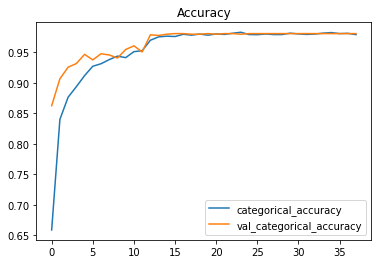

In [13]:
pd.DataFrame(results.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

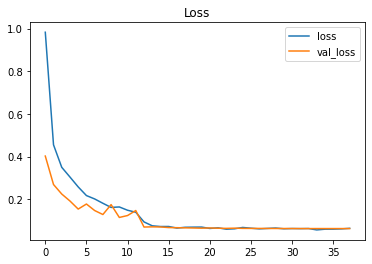

In [14]:
pd.DataFrame(results.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [15]:
MODEL_PATH = Path("./saved_model")
MODEL_PATH.mkdir(exist_ok=True)
efficientnet.save(str(MODEL_PATH))

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
# dump the training history as well
np.save('model_history.npy',results.history)

# history=np.load('model_history.npy',allow_pickle='TRUE').item()

# Model Evaluation

In [17]:
# Testing the model
results = efficientnet.evaluate(test)

35/35 [==============================] - 20s 569ms/step - loss: 0.0706 - categorical_accuracy: 0.9756


In [18]:
predictions = np.argmax(efficientnet.predict(test), axis=1)

### Classification Report

In [19]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

                           precision    recall  f1-score   support

              Black-grass       0.92      0.90      0.91        62
                 Charlock       1.00      1.00      1.00        90
                 Cleavers       1.00      1.00      1.00        67
         Common Chickweed       0.98      0.97      0.98       143
             Common wheat       1.00      1.00      1.00        51
                  Fat Hen       0.97      0.99      0.98       108
         Loose Silky-bent       0.95      0.97      0.96       152
                    Maize       1.00      1.00      1.00        51
        Scentless Mayweed       0.98      0.98      0.98       121
         Shepherd’s Purse       0.96      0.87      0.91        55
Small-flowered Cranesbill       0.97      0.99      0.98       115
               Sugar beet       1.00      0.99      0.99        93

                 accuracy                           0.98      1108
                macro avg       0.98      0.97      0.97    

### Confusion matrix

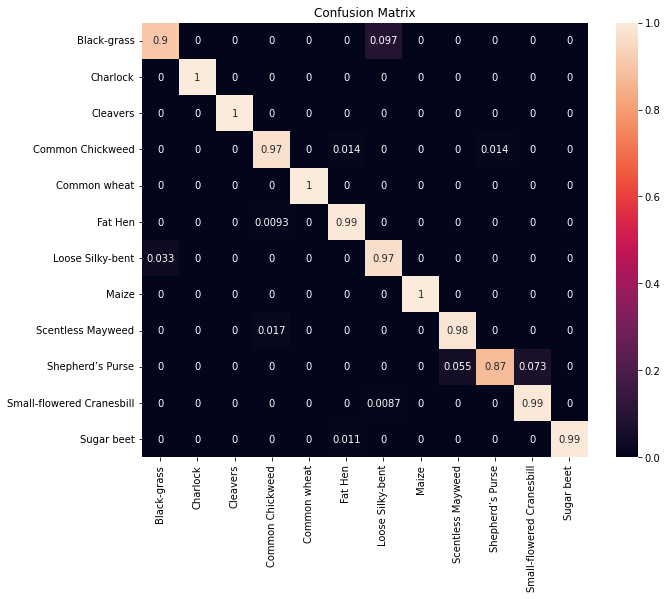

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()

In [36]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/kaggle/working/saved_model/')

In [37]:
import pandas as pd

# Create a dictionary with the data
data = {'Images': ['/kaggle/input/dataset123/Image.jpeg'], 'Labels': ['Unknown']}

# Create a pandas dataframe from the dictionary
df = pd.DataFrame(data)

# Print the dataframe
print(df)

                                              Images   Labels
0  /kaggle/input/dataset123/WhatsApp Image 2023-0...  Unknown


In [38]:
test_predict = test_generator_eff_net.flow_from_dataframe(
    dataframe=df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

Found 1 validated image filenames belonging to 1 classes.


In [39]:
predictions = loaded_model.predict(test_predict)

In [43]:
np.argmax(predictions)

9